
# Problem Statement

Flight ticket prices can be something hard to guess, today we might see a price, check out the price of the same flight tomorrow, it will be a different story. We might have often heard travelers saying that flight ticket prices are so unpredictable. 

As data scientists, we are gonna prove that given the right data anything can be predicted. Here you will be provided with prices of flight tickets for various airlines between the months of March and June of 2019 and between various cities. 

[![](https://images.newindianexpress.com/uploads/user/imagelibrary/2020/4/8/w900X450/millions.jpg)](https://images.newindianexpress.com/uploads/user/imagelibrary/2020/4/8/w900X450/millions.jpg)



# Import the relevant libraries in Python

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#-------------------------------------------------------------------------------------------------------------------------------
import pandas as pd                                                 # Importing package pandas (For Panel Data Analysis)
from pandas_profiling import ProfileReport                          # Import Pandas Profiling (To generate Univariate Analysis)
#-------------------------------------------------------------------------------------------------------------------------------
from sklearn import metrics
#-------------------------------------------------------------------------------------------------------------------------------
import numpy as np
#-------------------------------------------------------------------------------------------------------------------------------
# allow plots to appear directly in the notebook
%matplotlib inline

plt.rcParams['figure.figsize'] = 12, 7
import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
#-------------------------------------------------------------------------------------------------------------------------------
from timeit import default_timer as timer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing

from sklearn.feature_selection import RFE
import statsmodels.api as sm

In [2]:
train_data = pd.read_excel('Data_Train.xlsx')

In [3]:
train_data.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [5]:
train_data.describe(include='all')

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
count,10683,10683,10683,10683,10682,10683,10683,10683,10682,10683,10683.000000
unique,12,44,5,6,128,222,1343,368,5,10,NaN
top,Jet Airways,18/05/2019,Delhi,Cochin,DEL → BOM → COK,18:55,19:00,2h 50m,1 stop,No info,NaN
freq,3849,504,4537,4537,2376,233,423,550,5625,8345,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9087.064121
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4611.359167
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1759.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5277.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8372.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12373.000000


- Training data is combination of both categorical and numerical also we can see some special character also being used because of which we have to do data Transformation on it before applying it to our model

In [6]:
profile = train_data.profile_report(title="Flight Price Profiling before Data Preprocessing", progress_bar=False, minimal=True)
profile.to_file(output_file="flight_price_before_preprocessing.html")

**Observations**

- Airline column is a categorical variable with 12 distinct values and we can use OneHotEncoding to transform this column as it is a Nominal data

- We can observe that Date_of_Journey is in the form of date and all the data is for year 2019. So we will be extracting Date and month from this column and will be used for our model evaluation

- Source is a Nominal Categorical data with 5 distinct values and we will be using OnehotEncoding to transform this column

- Destination is a Nominal Categorical data with 6 distinct values and we will be using OnehotEncoding to transform this column

- We can drop off Route colum as we can derive the same information from Total_Stops. Here Route and Total_Stops will be highly correlated and this will cause Multicolinearity issue during our model building. 

- Dep_Time, Arrival_Time and Duration are in the form of HH:MM and model cannot use this format to build relationships, so we will be extracting hours and minutes into two different columns

- Total_Stops is an ordinal categorical variable with 5 distinct values and we will be using Label Encoder to transform this column

- 78% of the data for Additional_Info is having no information so we can drop this column as this will not give significant insight for our model evaluation

- Since we have less than 0.1% of missing values it is better to drop these observations

In [10]:
train_data.dropna(inplace=True)

In [11]:
train_data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [12]:
# Taking the copy of train dataset
train_data_copy = train_data.copy()
print(train_data is train_data_copy)

False


# Feature Generation

### Working on Date_of_Journey column 

- In the column ‘Date_of_Journey’, we can see the date format is given as dd/mm/yyyy and as you can see the datatype is given as object So there is two ways to tackle this column, either convert the column into Timestamp or divide the column into date,Month ,Year. Here , i am splitting the columns


In [18]:
Journey_day = pd.to_datetime(train_data.Date_of_Journey, format="%d/%m/%Y").dt.day
Journey_month = pd.to_datetime(train_data.Date_of_Journey, format="%d/%m/%Y").dt.month

train_data = train_data.assign(Journey_day = pd.to_datetime(train_data.Date_of_Journey, format="%d/%m/%Y").dt.day,
             Journey_month = pd.to_datetime(train_data.Date_of_Journey, format="%d/%m/%Y").dt.month)

train_data.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5


In [19]:
# Since we have converted Date_of_Journey column into Date and month we can drop it as it is of no use.

train_data.drop(["Date_of_Journey"], axis = 1, inplace = True)

In [20]:
train_data.head(2)

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5


### Working on Dep_Time column 

- In the column ‘Dep_Time’,if we see we have combination of both time and month but we need only the time details out of it so we split the time into ‘Hours’ and ‘Minute’.

In [24]:
# Extracting Hours
Dep_hour = pd.to_datetime(train_data["Dep_Time"]).dt.hour

# Extracting Minutes
Dep_min = pd.to_datetime(train_data["Dep_Time"]).dt.minute

train_data = train_data.assign(Dep_hour = pd.to_datetime(train_data["Dep_Time"]).dt.hour, 
                Dep_min = pd.to_datetime(train_data["Dep_Time"]).dt.minute )
train_data.head(2)

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,22,20
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5,5,50


In [25]:
# Now we can drop Dep_Time as it is of no use
train_data.drop(["Dep_Time"], axis = 1, inplace = True)

In [26]:
train_data.head(2)

,Airline,Source,Destination,Route,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,22,20
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,13:15,7h 25m,2 stops,No info,7662,1,5,5,50


### Working on Arrival_Time

- In the column ‘Arrival_Time’,if we see we have combination of both time and month but we need only the time details out of it so we split the time into ‘Hours’ and ‘Minute’.

In [27]:
# Extracting Hours
Arrival_hour = pd.to_datetime(train_data["Arrival_Time"]).dt.hour

# Extracting Minutes
Arrival_min = pd.to_datetime(train_data["Arrival_Time"]).dt.minute

train_data = train_data.assign(Arrival_hour = pd.to_datetime(train_data["Arrival_Time"]).dt.hour, 
                Arrival_min = pd.to_datetime(train_data["Arrival_Time"]).dt.minute)
train_data.head(2)

,Airline,Source,Destination,Route,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,13:15,7h 25m,2 stops,No info,7662,1,5,5,50,13,15


In [28]:
# Now we can drop Arrival_Time as it is of no use
train_data.drop(["Arrival_Time"], axis = 1, inplace = True)

In [29]:
train_data.head(2)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15


### Working on Duration Column

In [32]:
# Time taken by plane to reach destination is called Duration
# It is the differnce betwwen Departure Time and Arrival time

# Assigning and converting Duration column into list
duration = list(train_data["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Check if duration contains only hour or mins
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))   # Extracts only minutes from duration

In [34]:
# Adding duration_hours and duration_mins list to train_data dataframe
train_data = train_data.assign(Duration_hours = duration_hours, 
                 Duration_mins = duration_mins)
train_data.head(2)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15,7,25


In [35]:
# Now we can drop Duration as it is of no use
train_data.drop(["Duration"], axis = 1, inplace = True)

In [36]:
train_data.head(2)

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25


## Handling Categorical Data

### Working on Airline column

- To convert categorical text data into model-understandable numerical data, we use the One Hot Encoding as Airline is Nominal Categorical data.

In [37]:
train_data.Airline.value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

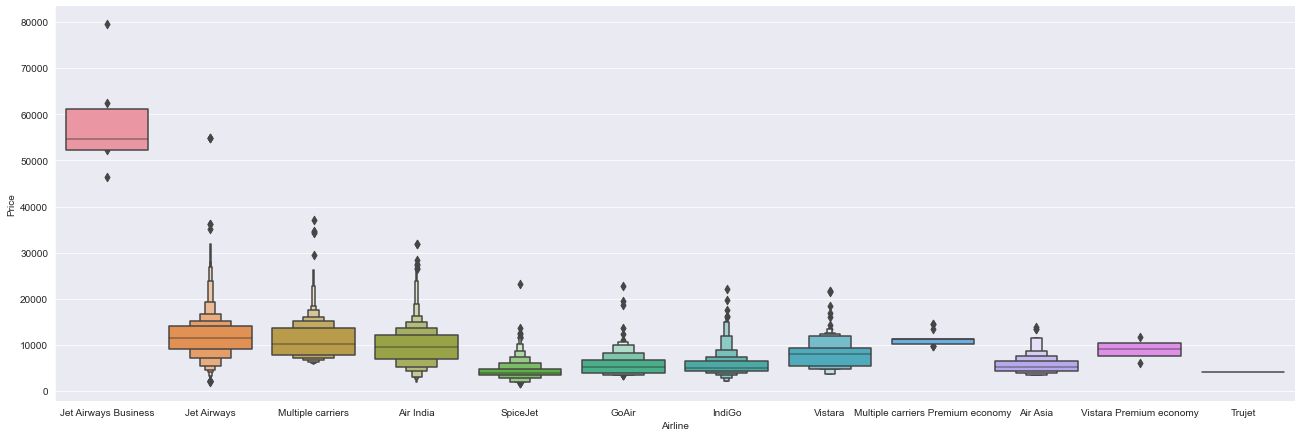

In [53]:
# Airline vs Price
sns.catplot(x='Airline', y='Price', data=train_data.sort_values('Price', ascending=False), kind='boxen',
           height = 6, aspect=3);


In [60]:
# As Airline is Nominal Categorical data we will perform OneHotEncoding

Airline = pd.DataFrame(train_data.loc[:, 'Airline'])
Airline = pd.get_dummies(Airline, drop_first=True)
Airline.head()

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


### Working on Source column

- To convert categorical text data into model-understandable numerical data, we use the One Hot Encoding as Source is Nominal Categorical data.

In [61]:
train_data.Source.value_counts()

Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

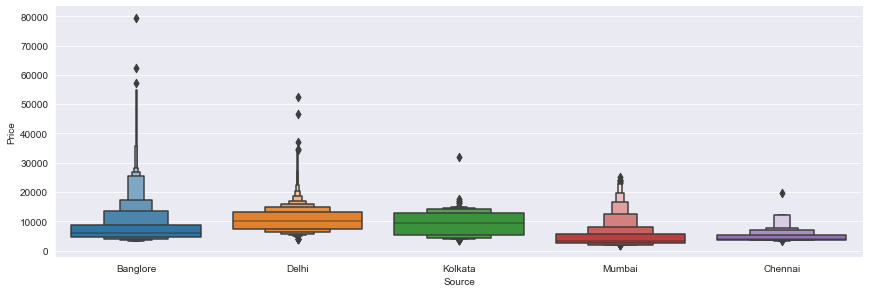

In [62]:
# Source vs Price
sns.catplot(y = "Price", x = "Source", data = train_data.sort_values("Price", ascending = False), kind="boxen", height = 4, aspect = 3)
plt.show()

In [66]:
# As Source is Nominal Categorical data we will perform OneHotEncoding

Source = pd.DataFrame(train_data.loc[:, 'Source'])
Source = pd.get_dummies(Source, drop_first=True)
Source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


### Working on Destination column 

- To convert categorical text data into model-understandable numerical data, we use the One Hot Encoding as Destination is Nominal Categorical data.

In [67]:
train_data.Destination.value_counts()

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [69]:
# As Destination is Nominal Categorical data we will perform OneHotEncoding

Destination = pd.DataFrame(train_data.loc[:, 'Destination'])
Destination = pd.get_dummies(Destination, drop_first=True)
Destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,0,0,0,1
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


#### - Dropping off Route column as we can derive the information from Total_Stops
#### - Dropping Additional_Info column as 80% of the data has no additional information 

In [70]:
train_data.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

### Working on Total_Stops column

- This column is combination of number and a categorical variable like ‘1 stop’ . So we need only the number details from this column so we split that and take the number details only also we change the ‘non stop’ into ‘0 stop’ and convert the column into integer type

In [71]:
train_data.Total_Stops.value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [75]:
# As this is case of Ordinal Categorical type we perform LabelEncoder
# Here Values are assigned with corresponding keys

train_data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

In [76]:
train_data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,0,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,1,13302,1,3,16,50,21,35,4,45


In [80]:
# Concatenate dataframe --> train_data + Airline + Source + Destination

data_train = pd.concat([train_data, Airline, Source, Destination], axis = 1)

In [81]:
data_train.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,...,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,IndiGo,Banglore,New Delhi,0,3897,24,3,22,20,1,...,0,0,0,0,0,0,0,0,0,1
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,...,0,0,0,1,0,0,0,0,0,0
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,...,0,0,1,0,0,1,0,0,0,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,...,0,0,0,1,0,0,0,0,0,0
4,IndiGo,Banglore,New Delhi,1,13302,1,3,16,50,21,...,0,0,0,0,0,0,0,0,0,1


In [82]:
# We can drop Airline, Source and Destination columns as we have transformed these data
data_train.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

In [83]:
data_train.head()

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,...,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,3897,24,3,22,20,1,10,2,50,...,0,0,0,0,0,0,0,0,0,1
1,2,7662,1,5,5,50,13,15,7,25,...,0,0,0,1,0,0,0,0,0,0
2,2,13882,9,6,9,25,4,25,19,0,...,0,0,1,0,0,1,0,0,0,0
3,1,6218,12,5,18,5,23,30,5,25,...,0,0,0,1,0,0,0,0,0,0
4,1,13302,1,3,16,50,21,35,4,45,...,0,0,0,0,0,0,0,0,0,1


## Reading Test dataset

In [84]:
test_data = pd.read_excel('Test_set.xlsx')

In [85]:
test_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [86]:
# Preprocessing

print("Test data Info")
print("-"*75)
print(test_data.info())

print()
print()

print("Null values :")
print("-"*75)
test_data.dropna(inplace = True)
print(test_data.isnull().sum())

# EDA

# Date_of_Journey
test_data["Journey_day"] = pd.to_datetime(test_data.Date_of_Journey, format="%d/%m/%Y").dt.day
test_data["Journey_month"] = pd.to_datetime(test_data["Date_of_Journey"], format = "%d/%m/%Y").dt.month
test_data.drop(["Date_of_Journey"], axis = 1, inplace = True)

# Dep_Time
test_data["Dep_hour"] = pd.to_datetime(test_data["Dep_Time"]).dt.hour
test_data["Dep_min"] = pd.to_datetime(test_data["Dep_Time"]).dt.minute
test_data.drop(["Dep_Time"], axis = 1, inplace = True)

# Arrival_Time
test_data["Arrival_hour"] = pd.to_datetime(test_data.Arrival_Time).dt.hour
test_data["Arrival_min"] = pd.to_datetime(test_data.Arrival_Time).dt.minute
test_data.drop(["Arrival_Time"], axis = 1, inplace = True)

# Duration
duration = list(test_data["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Check if duration contains only hour or mins
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))   # Extracts only minutes from duration

# Adding Duration column to test set
test_data["Duration_hours"] = duration_hours
test_data["Duration_mins"] = duration_mins
test_data.drop(["Duration"], axis = 1, inplace = True)


# Categorical data

print("Airline")
print("-"*75)
print(test_data["Airline"].value_counts())
Airline = pd.get_dummies(test_data["Airline"], drop_first= True)

print()

print("Source")
print("-"*75)
print(test_data["Source"].value_counts())
Source = pd.get_dummies(test_data["Source"], drop_first= True)

print()

print("Destination")
print("-"*75)
print(test_data["Destination"].value_counts())
Destination = pd.get_dummies(test_data["Destination"], drop_first = True)

# Additional_Info contains almost 80% no_info
# Route and Total_Stops are related to each other
test_data.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

# Replacing Total_Stops
test_data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

# Concatenate dataframe --> test_data + Airline + Source + Destination
data_test = pd.concat([test_data, Airline, Source, Destination], axis = 1)

data_test.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

print()
print()

print("Shape of test data : ", data_test.shape)

Test data Info
---------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Date_of_Journey  2671 non-null   object
 2   Source           2671 non-null   object
 3   Destination      2671 non-null   object
 4   Route            2671 non-null   object
 5   Dep_Time         2671 non-null   object
 6   Arrival_Time     2671 non-null   object
 7   Duration         2671 non-null   object
 8   Total_Stops      2671 non-null   object
 9   Additional_Info  2671 non-null   object
dtypes: object(10)
memory usage: 208.8+ KB
None


Null values :
---------------------------------------------------------------------------
Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time         

In [88]:
data_test.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Air India,...,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
0,1,6,6,17,30,4,25,10,55,0,...,0,0,1,0,0,1,0,0,0,0
1,1,12,5,6,20,10,20,4,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,21,5,19,15,19,0,23,45,0,...,0,0,1,0,0,1,0,0,0,0
3,1,21,5,8,0,21,0,13,0,0,...,0,0,1,0,0,1,0,0,0,0
4,0,24,6,23,55,2,45,2,50,0,...,0,0,0,0,0,0,1,0,0,0


# Feature Selection
Finding out the best feature which will contribute and have good relation with target variable. Following are some of the feature selection methods,

- **heatmap**
- **feature_importance_**
- **SelectKBest**

In [91]:
X = data_train.loc[:, data_train.columns != 'Price']

In [92]:
X.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,...,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,24,3,22,20,1,10,2,50,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1,5,5,50,13,15,7,25,1,...,0,0,0,1,0,0,0,0,0,0
2,2,9,6,9,25,4,25,19,0,0,...,0,0,1,0,0,1,0,0,0,0
3,1,12,5,18,5,23,30,5,25,0,...,0,0,0,1,0,0,0,0,0,0
4,1,1,3,16,50,21,35,4,45,0,...,0,0,0,0,0,0,0,0,0,1


In [96]:
y = data_train.Price

In [97]:
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

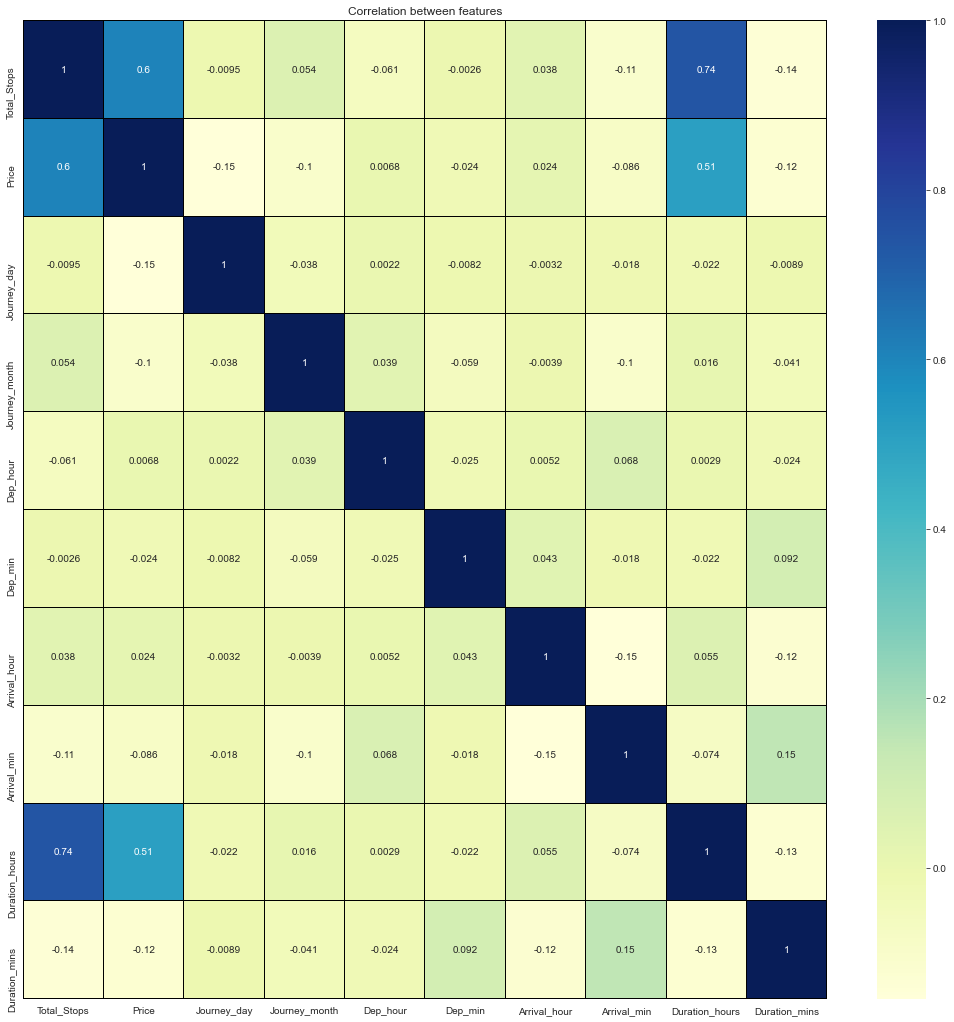

In [104]:
# Finds correlation between Independent and dependent attributes

plt.figure(figsize = (18,18))
sns.heatmap(train_data.corr(), annot = True, cmap = "YlGnBu", linecolor ='black', linewidth=.01)
plt.title('Correlation between features')
plt.show()

In [105]:
# Important feature using ExtraTreesRegressor

from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X, y)

ExtraTreesRegressor()

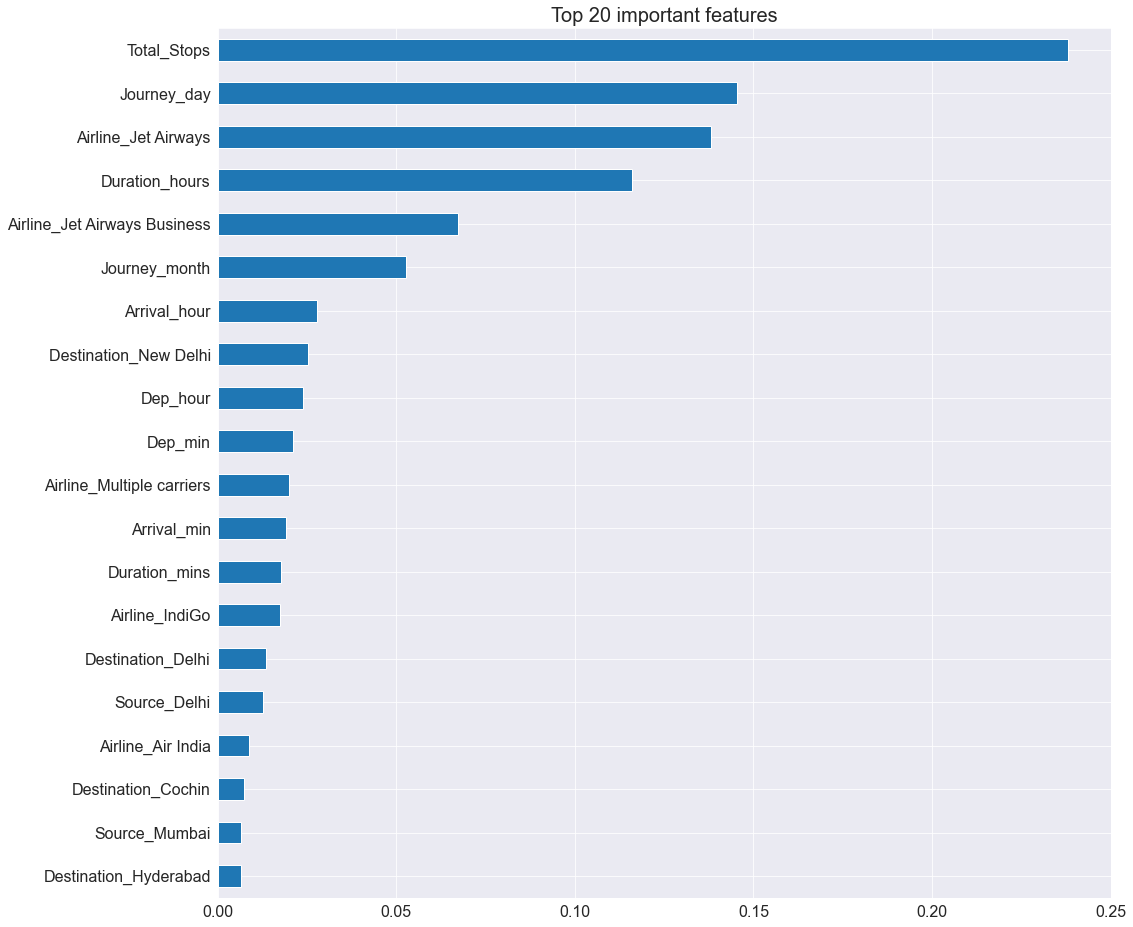

In [118]:
#plot graph of feature importances for better visualization

plt.figure(figsize = (16,16))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(20).sort_values().plot(kind='barh')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Top 20 important features', fontsize=20)
plt.show()

## Fitting model using Random Forest
- Split dataset into train and test set in order to prediction w.r.t X_test
- If needed do scaling of data
- Scaling is not done in Random forest
- Import model
- Fit the data
- Predict w.r.t X_test
- In regression check RSME Score
- Plot graph

In [119]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [120]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor()
reg_rf.fit(X_train, y_train)

RandomForestRegressor()

In [121]:
y_pred = reg_rf.predict(X_test)

In [122]:
reg_rf.score(X_train, y_train)

0.9531660030345361

In [123]:
reg_rf.score(X_test, y_test)

0.7983276891374081

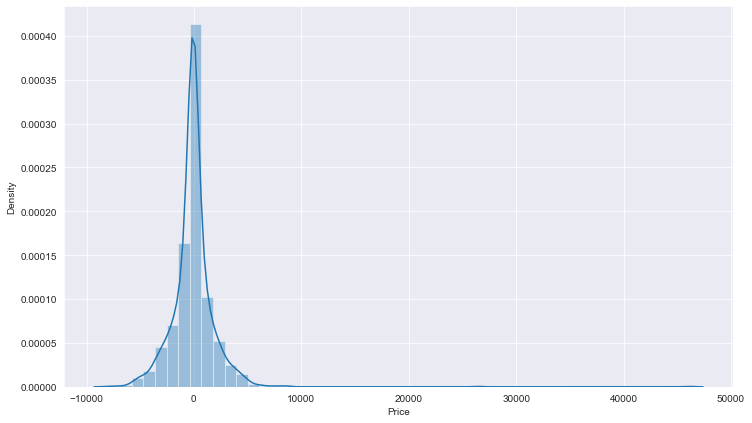

In [124]:
sns.distplot(y_test-y_pred)
plt.show()

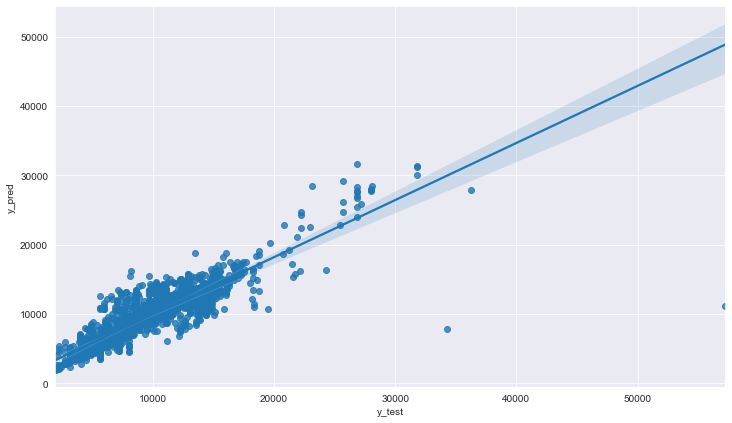

In [126]:
sns.regplot(y_test, y_pred)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [127]:
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

MAE: 1171.741395821643
MSE: 4348469.72584307
RMSE: 2085.298474042282


In [130]:
r_squared = r2_score(y_test, y_pred)
r_squared

0.7983276891374081

In [131]:
adjusted_r_squared = 1 - (1-r_squared)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print(r_squared, adjusted_r_squared)

0.7983276891374081 0.797640842746919


## Hyperparameter Tuning

In [132]:
from sklearn.model_selection import RandomizedSearchCV

In [134]:
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]


In [135]:
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [137]:
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = reg_rf, 
                               param_distributions = random_grid, scoring='neg_mean_squared_error', 
                               n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = -1)

In [138]:
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=  10.8s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.7s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   9.9s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=  10.0s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=  10.4s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=  10.6s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15 
[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, total=  15.2s
[CV] n_estimators=1100, min_samples_split=10, mi

[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   4.3s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   4.5s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   4.9s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   4.9s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   4.9s
[CV] n_estimators=700, min_samples_split=15, min_sam

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 12.2min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [139]:
rf_random.best_params_

{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

In [140]:
prediction = rf_random.predict(X_test)

In [142]:
print('MAE:', mean_absolute_error(y_test, prediction))
print('MSE:', mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(mean_squared_error(y_test, prediction)))

MAE: 1167.1314678260926
MSE: 4066721.219069999
RMSE: 2016.6113207730436


In [143]:
r_squared = r2_score(y_test, prediction)
r_squared

0.8113945554203494

In [144]:
adjusted_r_squared = 1 - (1-r_squared)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print(r_squared, adjusted_r_squared)

0.8113945554203494 0.810752211569168


## Save the model to reuse it again

In [158]:
import pickle
# open a file, where you ant to store the data
file = open('flight_rf.pkl', 'wb')

# dump information to that file
pickle.dump(rf_random, file)

In [159]:
model = open('flight_rf.pkl','rb')
forest = pickle.load(model)

In [160]:
y_prediction = forest.predict(X_test)

In [161]:
r2_score(y_test, y_prediction)

0.8113945554203494

In [156]:
! pip freeze > requirements. txt 